In [1]:
import pandas as pd
import numpy as np
import datetime

from epiweeks import Week
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
import scipy.stats as stats
import matplotlib.colors as mcolors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap


import geopandas as gpd
from mpl_toolkits.basemap import Basemap as Basemap


import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
#lump all trajectories together and calculate energy score for each location/scenario

In [36]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})
#include all models, even those submitted for just one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']
    

# get surveillance data
incidence = True 
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")

observations['date'] = pd.to_datetime(observations['date'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())


energyscoresdf = pd.DataFrame()

predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
loclist = list(predictionsall.location.unique())


for loc in loclist:
    if loc in ['60','66','69', '72', '78']:
        continue
    for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:
        location = loc
        target = 'hosp'
        incidence = True

        if target == 'hosp':
            target_obs = 'hospitalization'
        else:
            target_obs = target_obs
            
        # filter projections to calculate score for each scenario and location
        predictionsfilt = predictionsall[(predictionsall.scenario_id == scenario + '-2023-08-14') & \
                                    (predictionsall.location == location) & \
                                    (predictionsall.target == 'inc ' + target)  & \
                                    (predictionsall.target_end_date <= max_date) & \
                                    (predictionsall.target_end_date >= start_week)]

        # get observations
        observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
        observations['date'] = pd.to_datetime(observations['date'])

        observations = observations[(observations['date'] >= start_week) & \
                                    (observations['date'] <= max_date)]   

        #filter location
        observations = observations[observations['location'] == location]

        #aggregate to weekly
        observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

        #transform to Observation object
        observations = Observations(observations)

        # calculate energy score
        y = np.array(observations.value)
        X = [np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) for i in predictionsfilt.trajectory_id.unique()]

        ES = energyscore(np.array(X),y)
        
        # save data
        if loc == 'US':
            loc_conv = loc
        elif int(loc) <10:
            loc_conv = loc[1]
        else:
            loc_conv = loc  

        newrow = pd.DataFrame({'Label': 'Scenario '+ scenario, 'location':loc_conv,  
                            'target':target, 'energyscore': ES}, index=[0])

        energyscoresdf = pd.concat([energyscoresdf, newrow])

energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   


energyscoresdf = pd.merge(energyscoresdf, locations, how = 'inner', on = 'location')


In [37]:
energyscoresdf

,Label,location,target,energyscore,abbreviation,location_name,population
0,Scenario A,1,hosp,352.242375,AL,Alabama,4903185
1,Scenario B,1,hosp,288.045092,AL,Alabama,4903185
2,Scenario C,1,hosp,379.595429,AL,Alabama,4903185
3,Scenario D,1,hosp,308.190889,AL,Alabama,4903185
4,Scenario E,1,hosp,409.700587,AL,Alabama,4903185
...,...,...,...,...,...,...,...
307,Scenario B,US,hosp,16185.663861,US,US,328728466
308,Scenario C,US,hosp,17308.352348,US,US,328728466
309,Scenario D,US,hosp,15671.225791,US,US,328728466
310,Scenario E,US,hosp,18840.344966,US,US,328728466


In [38]:
energyscoresdf.to_pickle("../fludat/energyscore_trajensemble_rd4_hosp_118.pkl")

create energy score ratio to compare ensemble to naive baseline model

In [187]:
# get 4-week-ahead naive baseline model scores

baseline = pd.read_pickle('../fludat/flu-baseline_energyscore_118.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})
baseline = baseline[baseline.location!='US']
baseline['location'] = baseline['location'].astype(int)

# ensemble energy scores
ensembledf = pd.read_pickle("../fludat/energyscore_trajensemble_rd4_hosp_118.pkl")
ensembledf['target'] = 'inc hosp'
ensembledf= ensembledf[ensembledf.location!='US']
ensembledf['location'] = ensembledf['location'].astype(int)
ensembledf['Model'] = 'Ensemble'

# calculate energy score ratio
ES_ratiodf = ensembledf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']

In [188]:
# look only at scenario D and US states
df = ES_ratiodf[['Model', 'Label', 'location', 'abbreviation', 'location_name', 'ES_ratio']]
df = df[(df.Label=='Scenario D') ]

In [190]:
len(df[df.ES_ratio>1])

27

create map of scores

In [152]:
us = gpd.read_file('../cb_2018_us_state_500k')
us = us.rename(columns={'STATEFP':'location'})
us['location'] = us['location'].astype(int)

# Merge datasets
merged = us.merge(df.groupby(by='location').mean(), how='left', left_on='location', right_on='location')


<Axes: >

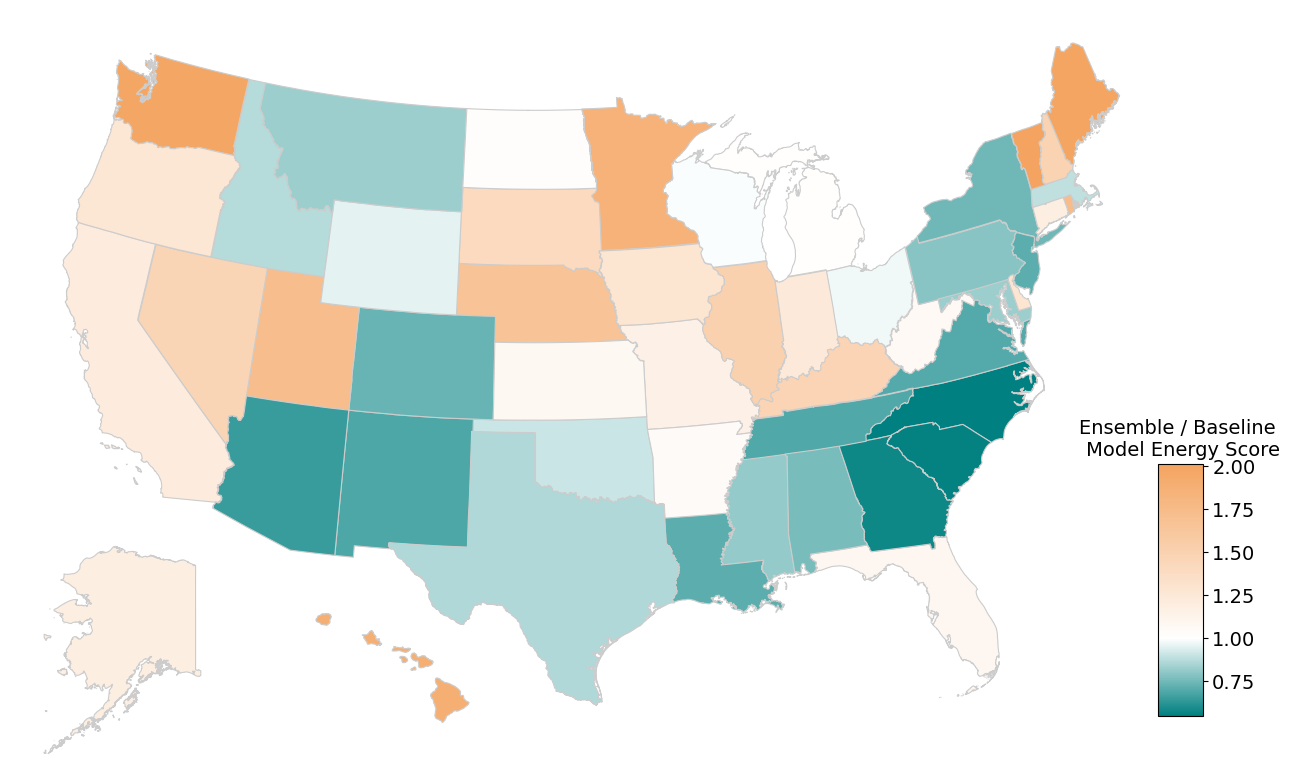

In [153]:
variable = 'ES_ratio'

colors = ['teal', 'white', 'sandybrown']
# Create a colormap from the list of colors
cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)

def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

gdf = merged.copy()

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.ES_ratio.min(), gdf.ES_ratio.max() 
colormap = cmap
gdf = makeColorColumn(gdf,variable,vmin,vmax)
visframe = gdf.to_crs({'init':'epsg:2163'})


# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 12))
# remove the axis box around the vis
ax.axis('off')
#ax.set_xlim([-6,3])


# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.21])   

cbax.set_title('Ensemble / Baseline \n Model Energy Score', fontdict={'fontsize': '14', 'fontweight' : '0'})

# add color scale

sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax))


# reformat tick labels on legend
sm._A = []
cbar = fig.colorbar(sm, cax=cbax, spacing='proportional')
tick_font_size = 14
cbax.tick_params(labelsize=tick_font_size)
cbar.ax.set_yscale('linear')


# create map
for row in visframe.itertuples():
    if row.location not in [2, 15, 72, 69, 78, 60, 66]:
        vf = visframe[visframe.location==row.location]
        c = gdf[gdf.location==row.location][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.location==2]
alaska_gdf.clip(polygon).plot(color=gdf[gdf.location==2].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.2, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.location==15]
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


#fig.savefig('../figs/ESratio_ensemble_map1205.pdf', bbox_inches="tight")

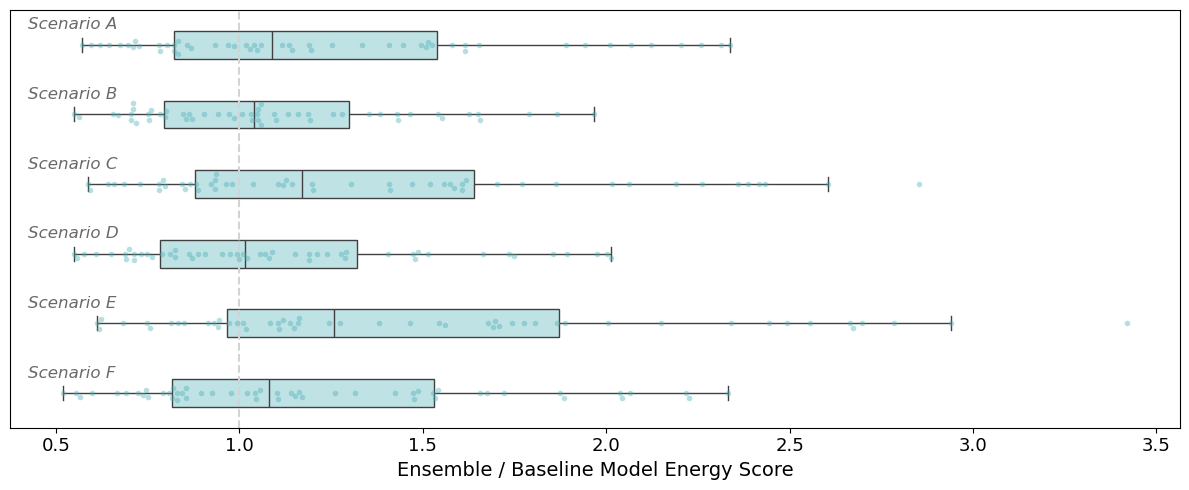

In [203]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
#plt.subplots_adjust(hspace=4)
i=1

baseline = pd.read_pickle('../fludat/flu-baseline_energyscore_118.pkl').rename(columns={'energyscore':'energyscore_baseline',
                                                                           'Model':'baseline_model'})

energyscoresdf = pd.read_pickle("../fludat/energyscore_trajensemble_rd4_hosp_118.pkl")
energyscoresdf['target'] = 'inc hosp'
energyscoresdf['location'] = energyscoresdf['location'].apply(lambda x: '0'+x if len(x)<2 else x)


# calculate energy score ratio
ES_ratiodf = energyscoresdf.merge(baseline, on = ['location', 'target'])
ES_ratiodf['ES_ratio'] = ES_ratiodf['energyscore'] / ES_ratiodf['energyscore_baseline']    
rankinfo = ES_ratiodf.copy()


my_order = rankinfo.Label.unique()

g = sns.boxplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order, color = '#17B1BF', width=0.4,
               showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
# plot underlying distribution
sns.swarmplot(x='ES_ratio', y='Label', data=rankinfo,order=my_order,color = "#49AFB7",alpha = .4,size=4,
              orient="h")  

g.set(yticklabels=[])
g.set(yticks=[])

plt.ylabel('', fontsize=15)
plt.xlabel('Ensemble / Baseline Model Energy Score', fontsize=14)

i+=1 

plt.axvline(x=1, ymin=0, ymax=3,linestyle='--', color = 'lightgray', alpha=1)

a = 0
for mod in list(my_order):
    plt.text(0.425,a-.22, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xticks(fontsize=13)
plt.tight_layout()

plt.savefig('../figs/ensemble_ESdist_1211.pdf')
plt.show()


In [204]:
df = rankinfo.groupby(['Label']).ES_ratio.describe(percentiles=[.05,.5,.95]).drop(columns=['mean',
                                                         'std']).round(2)

In [202]:
df.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &  count &   min &    5\\% &   50\\% &   95\\% &   max \\\\\nLabel      &        &       &       &       &       &       \\\\\n\\midrule\nScenario A &   52.0 &  0.57 &  0.63 &  1.09 &  2.23 &  2.34 \\\\\nScenario B &   52.0 &  0.55 &  0.66 &  1.04 &  1.72 &  1.97 \\\\\nScenario C &   52.0 &  0.59 &  0.65 &  1.17 &  2.42 &  2.85 \\\\\nScenario D &   52.0 &  0.55 &  0.59 &  1.02 &  1.93 &  2.01 \\\\\nScenario E &   52.0 &  0.61 &  0.65 &  1.26 &  2.74 &  3.42 \\\\\nScenario F &   52.0 &  0.52 &  0.58 &  1.08 &  2.13 &  2.33 \\\\\n\\bottomrule\n\\end{tabular}\n'